## RESULTS SECTION SCRIPTS/CALCULATIONS

## Percentiles

In [1]:
import rasterio
import numpy as np

with rasterio.open("/Users/inesschwartz/Desktop/model/bagged_maps/v3_RFOK_SOC_MgC_ha_mean.tif") as src:
    data = src.read(1)
    data = data[~np.isnan(data)]

p90 = np.percentile(data, 90)
print("P90 =", p90)


P90 = 5.378965854644775


In [3]:
import rasterio
import numpy as np

with rasterio.open("/Users/inesschwartz/Desktop/model/bagged_maps/v3_RFOK_SOC_MgC_ha_mean.tif") as src:
    data = src.read(1)
    data = data[~np.isnan(data)]

p10 = np.percentile(data, 10)
print("P10 =", p10)


P10 = 2.4290479183197022


## soc by admin 1 (district)

In [18]:
## soc by admin 1 (district)

import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import pandas as pd

# ---------------------------
# File paths
# ---------------------------
soc_tif = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RFOK_SOC_mean_MgHa_corrected.tif"
admin1_shp = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_raw/angolaadminboundaries/ago_admbnda_gadm_ine_ocha_20180904/ago_admbnda_adm1_gadm_ine_ocha_20180904.shp"

# Pixel area (1 km × 1 km = 100 ha)
pixel_area_ha = 100.0

# ---------------------------
# Read SOC raster
# ---------------------------
with rasterio.open(soc_tif) as src:
    soc = src.read(1).astype(float)
    soc_nodata = src.nodata
    transform = src.transform
    crs = src.crs
    out_shape = soc.shape

# Mask SOC nodata
soc[soc == soc_nodata] = np.nan

# ---------------------------
# Read Admin-1 boundaries
# ---------------------------
admin1_gdf = gpd.read_file(admin1_shp)

# Reproject Admin-1 to SOC CRS if needed
if admin1_gdf.crs != crs:
    admin1_gdf = admin1_gdf.to_crs(crs)

# Use an ID field (adjust if your shapefile uses a different name)
# Common options: "ADM1_EN", "NAME_1", "HASC_1"
admin1_gdf["adm1_id"] = admin1_gdf.index + 1
admin1_name_field = "ADM1_EN"  # change if needed

# ---------------------------
# Rasterize Admin-1 polygons
# ---------------------------
admin1_raster = rasterize(
    [(geom, value) for geom, value in zip(admin1_gdf.geometry, admin1_gdf["adm1_id"])],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="int32"
)

# ---------------------------
# Build analysis DataFrame
# ---------------------------
mask = (~np.isnan(soc)) & (admin1_raster > 0)

df = pd.DataFrame({
    "adm1_id": admin1_raster[mask],
    "soc": soc[mask]
})

# ---------------------------
# Summarize SOC by Admin-1
# ---------------------------
summary = df.groupby("adm1_id").agg(
    mean_SOC=("soc", "mean"),
    median_SOC=("soc", "median"),
    std_SOC=("soc", "std"),
    min_SOC=("soc", "min"),
    max_SOC=("soc", "max"),
    n_pixels=("soc", "count"),
)

# Coefficient of variation
summary["CV"] = summary["std_SOC"] / summary["mean_SOC"]

# Total SOC stock (Mg C)
summary["total_C_stock_Mg"] = summary["mean_SOC"] * summary["n_pixels"] * pixel_area_ha

# ---------------------------
# Join Admin-1 names
# ---------------------------
summary = summary.merge(
    admin1_gdf[["adm1_id", admin1_name_field]],
    on="adm1_id",
    how="left"
)

summary = summary.rename(columns={admin1_name_field: "Admin1_Name"})

# Sort by total stock
summary = summary.sort_values("total_C_stock_Mg", ascending=False)

print(summary)


    adm1_id  mean_SOC  median_SOC   std_SOC   min_SOC    max_SOC  n_pixels  \
14       15  4.152659    3.756510  1.029098  2.470994   9.130691    202008   
4         5  3.043853    3.002286  0.345272  2.261971   5.613685    200469   
11       12  5.475230    5.470205  0.567775  3.691504   7.762702     99602   
13       14  4.850679    4.820552  0.851958  2.939486   9.105047     88505   
12       13  4.847814    4.866563  0.423361  3.613867   6.713320     81335   
16       17  5.968079    5.773477  1.178521  3.653171  11.069095     61966   
2         3  4.028101    3.905575  0.707749  2.838349   7.552139     72122   
6         7  4.984150    4.886657  0.803549  2.785072   8.053665     55214   
9        10  3.435236    3.331089  0.600668  1.929323   6.251516     78635   
17       18  5.528942    5.571474  0.950848  2.525019   9.864010     36588   
7         8  2.568171    2.616144  0.314328  1.531473   5.459253     77112   
1         2  3.639277    3.402203  1.171311  1.624626   7.109200

In [19]:
# Attach Admin-1 names BEFORE exporting CSV
summary = summary.merge(
    admin1_gdf[["adm1_id", "ADM1_EN"]],
    on="adm1_id",
    how="left"
)

summary.to_csv(
    "/Users/inesschwartz/Desktop/model/soc_results/SOC_by_Admin1.csv",
    index=False
)


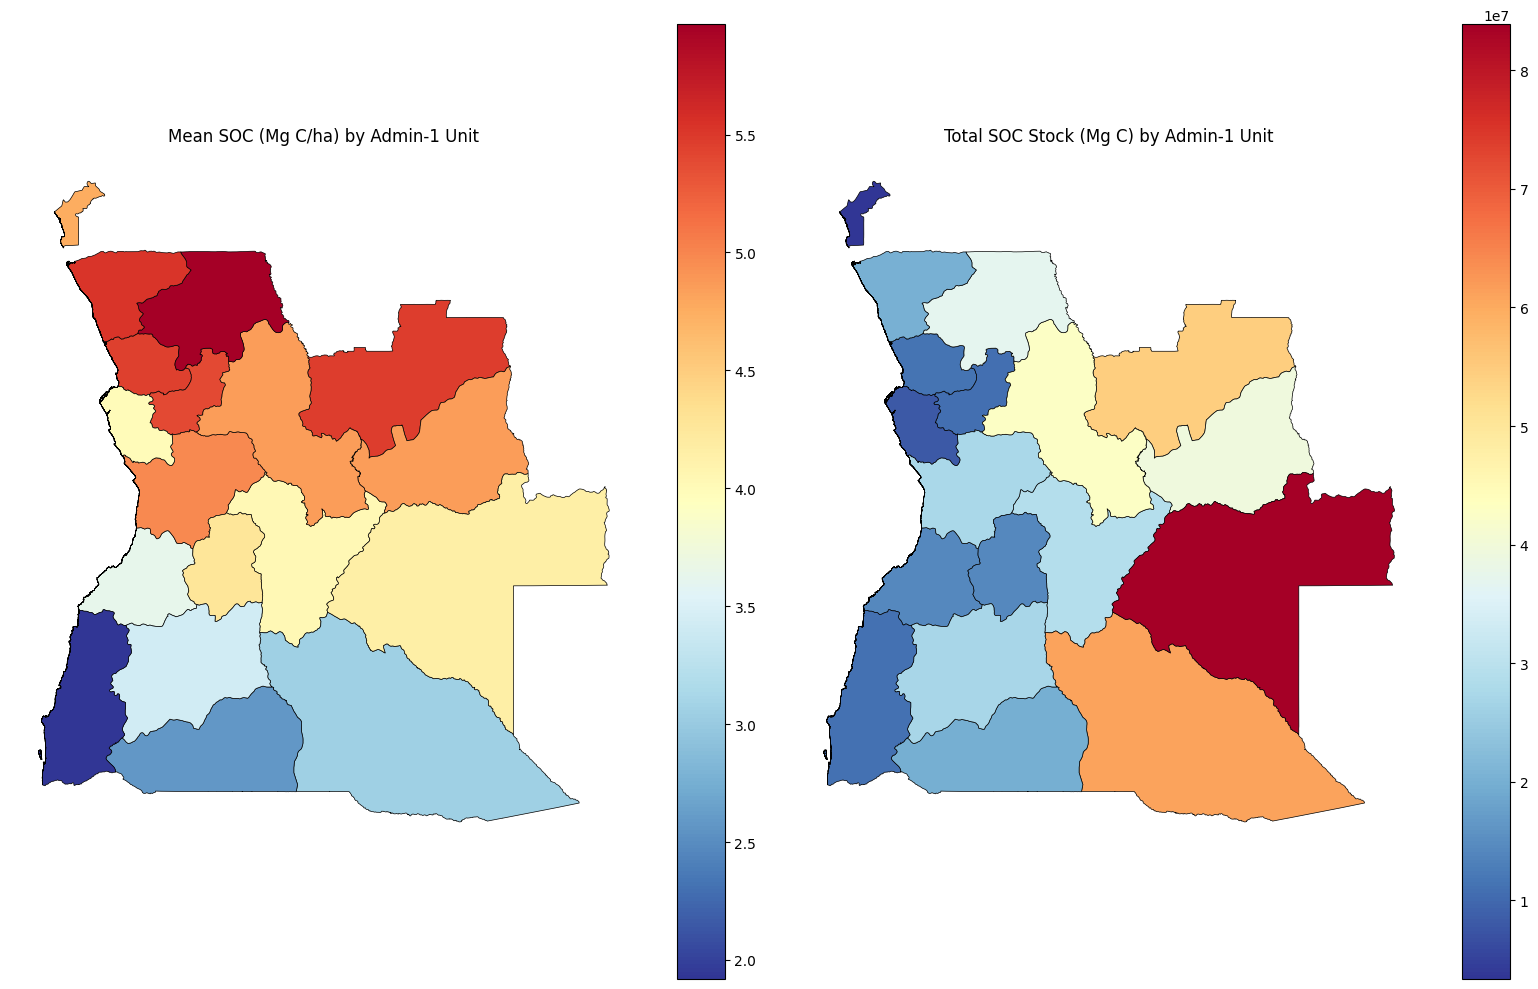

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Paths
# -----------------------------
admin1_shp = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_raw/angolaadminboundaries/ago_admbnda_gadm_ine_ocha_20180904/ago_admbnda_adm1_gadm_ine_ocha_20180904.shp"
soc_csv = "/Users/inesschwartz/Desktop/model/soc_results/SOC_by_Admin1.csv"

# -----------------------------
# Load data
# -----------------------------
admin1 = gpd.read_file(admin1_shp)
soc = pd.read_csv(soc_csv)

# Merge on Admin1 name
admin1 = admin1.merge(soc, left_on="ADM1_EN", right_on="Admin1_Name", how="left")

# -----------------------------
# Plot side by side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Mean SOC
admin1.plot(
    column="mean_SOC",
    cmap="RdYlBu_r",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Mean SOC (Mg C/ha) by Admin-1 Unit", fontsize=12)
axes[0].axis("off")

# Total SOC
admin1.plot(
    column="total_C_stock_Mg",
    cmap="RdYlBu_r",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Total SOC Stock (Mg C) by Admin-1 Unit", fontsize=12)
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [14]:
print("National total from districts:",
      admin1["total_C_stock_Mg"].sum())


National total from districts: 474273762.040925


In [23]:
import rasterio
import numpy as np

# --------------------------------
# INPUT
# --------------------------------
soc_tif = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RFOK_SOC_mean_MgHa_corrected.tif"

# Pixel area (1 km × 1 km = 100 ha)
pixel_area_ha = 100.0

# --------------------------------
# READ RASTER
# --------------------------------
with rasterio.open(soc_tif) as src:
    soc = src.read(1).astype(float)
    nodata = src.nodata

# Mask nodata
soc[soc == nodata] = np.nan

# --------------------------------
# BASIC STATISTICS
# --------------------------------
valid = soc[np.isfinite(soc)]

mean_soc = np.mean(valid)
min_soc = np.min(valid)
max_soc = np.max(valid)
std_soc = np.std(valid)
cv_soc = std_soc / mean_soc

# --------------------------------
# TOTAL SOC STOCK
# --------------------------------
n_pixels = valid.size
total_soc_stock = mean_soc * n_pixels * pixel_area_ha  # Mg C

# --------------------------------
# PRINT RESULTS
# --------------------------------
print("=" * 60)
print("SOC STATISTICS FROM RASTER")
print("=" * 60)

print(f"Mean SOC: {mean_soc:.2f} Mg C ha⁻¹")
print(f"Min SOC:  {min_soc:.2f} Mg C ha⁻¹")
print(f"Max SOC:  {max_soc:.2f} Mg C ha⁻¹")
print(f"Std SOC:  {std_soc:.2f} Mg C ha⁻¹")
print(f"CV:       {cv_soc:.3f}")

print("\nTOTAL SOC STOCK")
print(f"Total SOC stock: {total_soc_stock:,.0f} Mg C")

print("=" * 60)


SOC STATISTICS FROM RASTER
Mean SOC: 4.12 Mg C ha⁻¹
Min SOC:  1.38 Mg C ha⁻¹
Max SOC:  11.07 Mg C ha⁻¹
Std SOC:  1.30 Mg C ha⁻¹
CV:       0.316

TOTAL SOC STOCK
Total SOC stock: 518,837,141 Mg C


In [24]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import features

# -----------------------------
# INPUT FILES
# -----------------------------
test1_csv = "/Users/inesschwartz/Desktop/model/model_datasets/test_data.csv"
soc_raster = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RFOK_SOC_mean_MgHa_corrected.tif"
pixel_area_ha = 100.0  # 1 km x 1 km pixel

# -----------------------------
# LOAD TEST1 OBSERVED SOC
# -----------------------------
test1 = pd.read_csv(test1_csv)

# Convert log SOC to Mg C/ha
test1['SOC_obs'] = np.exp(test1['log_soc_stock'])

# Extract coordinates
coords = list(zip(test1['X_coord'], test1['Y_coord']))

# -----------------------------
# OPEN SOC RASTER
# -----------------------------
with rasterio.open(soc_raster) as src:
    soc_map = src.read(1).astype(float)
    nodata = src.nodata
    transform = src.transform

    # Function to convert coords to row/col
    def coord_to_index(xy):
        row, col = ~transform * xy
        return int(row), int(col)

    # Extract predicted SOC at Test1 points
    pred_list = []
    for xy in coords:
        row, col = coord_to_index(xy)
        # Clip row/col to raster bounds
        row = min(max(row, 0), soc_map.shape[0]-1)
        col = min(max(col, 0), soc_map.shape[1]-1)
        val = soc_map[row, col]
        if val == nodata:
            val = np.nan
        pred_list.append(val)

test1['SOC_pred'] = pred_list

# Remove any NaNs
test1 = test1.dropna(subset=['SOC_pred', 'SOC_obs'])

# -----------------------------
# COMPUTE BIAS
# -----------------------------
bias = (test1['SOC_pred'] - test1['SOC_obs']).mean()
print("="*60)
print(f"Bias (predicted - observed) = {bias:.3f} Mg C/ha")
print("="*60)

# -----------------------------
# APPLY BIAS CORRECTION TO RASTER
# -----------------------------
soc_corrected = np.where(
    np.isfinite(soc_map),
    soc_map - bias,
    np.nan
)

# -----------------------------
# COMPUTE STATISTICS
# -----------------------------
valid = soc_corrected[np.isfinite(soc_corrected)]

mean_soc = np.mean(valid)
min_soc = np.min(valid)
max_soc = np.max(valid)
std_soc = np.std(valid)
cv_soc = std_soc / mean_soc
total_soc_stock = mean_soc * valid.size * pixel_area_ha

print("\nSTATISTICS OF BIAS-CORRECTED SOC RASTER")
print(f"Mean SOC: {mean_soc:.2f} Mg C/ha")
print(f"Min SOC:  {min_soc:.2f} Mg C/ha")
print(f"Max SOC:  {max_soc:.2f} Mg C/ha")
print(f"Std SOC:  {std_soc:.2f} Mg C/ha")
print(f"CV:       {cv_soc:.3f}")
print(f"Total SOC stock: {total_soc_stock:,.0f} Mg C")

# -----------------------------
# OPTIONAL: SAVE BIAS-CORRECTED RASTER
# -----------------------------
output_raster = soc_raster.replace(".tif", "_bias_corrected.tif")
with rasterio.open(soc_raster) as src:
    meta = src.meta.copy()
    meta.update(dtype=rasterio.float32, nodata=np.nan)

    with rasterio.open(output_raster, "w", **meta) as dst:
        dst.write(soc_corrected.astype(np.float32), 1)

print(f"\n✅ Bias-corrected raster saved to: {output_raster}")


Bias (predicted - observed) = 0.192 Mg C/ha

STATISTICS OF BIAS-CORRECTED SOC RASTER
Mean SOC: 3.93 Mg C/ha
Min SOC:  1.19 Mg C/ha
Max SOC:  10.88 Mg C/ha
Std SOC:  1.30 Mg C/ha
CV:       0.332
Total SOC stock: 494,678,243 Mg C

✅ Bias-corrected raster saved to: /Users/inesschwartz/Desktop/model/bagged_maps_corrected/RFOK_SOC_mean_MgHa_corrected_bias_corrected.tif


## looking at bias of residuals

In [25]:
import pandas as pd
import rasterio
import numpy as np

# -----------------------------
# Load Test1 CSV
# -----------------------------
test1 = pd.read_csv("/Users/inesschwartz/Desktop/model/model_datasets/test_data.csv")  # adjust path
test1['SOC_obs'] = np.exp(test1['log_soc_stock'])  # back-transform to Mg C/ha

# -----------------------------
# Load RF+OK raster
# -----------------------------
raster_path = "/Users/inesschwartz/Desktop/model/bagged_maps_corrected/RFOK_SOC_mean_MgHa_corrected.tif"
raster = rasterio.open(raster_path)

# Extract predicted SOC at Test1 coordinates
coords = [(x, y) for x, y in zip(test1['X_coord'], test1['Y_coord'])]
test1['SOC_pred'] = [x[0] for x in raster.sample(coords)]

# -----------------------------
# Compute residuals
# -----------------------------
test1['residual'] = test1['SOC_pred'] - test1['SOC_obs']


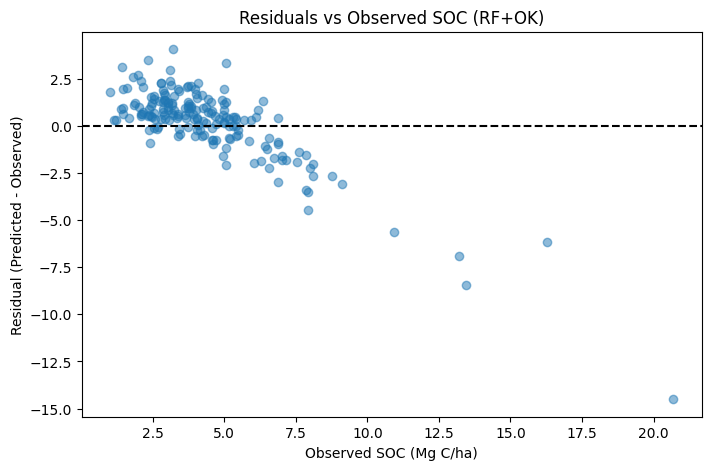

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(test1['SOC_obs'], test1['residual'], alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Observed SOC (Mg C/ha)")
plt.ylabel("Residual (Predicted - Observed)")
plt.title("Residuals vs Observed SOC (RF+OK)")
plt.show()


In [27]:
# Top 10% of SOC
high_SOC_threshold = test1['SOC_obs'].quantile(0.9)
high_SOC_residuals = test1.loc[test1['SOC_obs'] >= high_SOC_threshold, 'residual']
mean_high_SOC_residual = high_SOC_residuals.mean()

print(f"Mean residual for top 10% observed SOC: {mean_high_SOC_residual:.2f} Mg C/ha")


Mean residual for top 10% observed SOC: -4.00 Mg C/ha


In [29]:
bias = test1['residual'].mean()
rmse = np.sqrt((test1['residual']**2).mean())
mae = test1['residual'].abs().mean()
r2 = 1 - ((test1['residual']**2).sum() / ((test1['SOC_obs'] - test1['SOC_obs'].mean())**2).sum())

print(f"Bias: {bias:.2f} Mg C/ha")
print(f"RMSE: {rmse:.2f} Mg C/ha")
print(f"MAE: {mae:.2f} Mg C/ha")
print(f"R²: {r2:.2f}")


Bias: 0.17 Mg C/ha
RMSE: 2.04 Mg C/ha
MAE: 1.34 Mg C/ha
R²: 0.34
